In [117]:
import nppar
import time
import numpy as np
import math
import datatable as dt
import time
import xarray
import os
import fileutils
import traceback
from datetime import datetime
import multiprocessing as mp
import random
from functools import partial
from multiprocessing import Pool, Array, Process, Manager
from functools import partial
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axes_grid1

In [31]:
def gridinfo():
    rdiff=2227
    minnorth=333237
    #maxwest=1160624
    minwest=1156167
    maxeast=2747676
    maxsouth=3504175
    gridwidth=((maxeast-minwest) % rdiff) + 1
    firstid = minwest-math.ceil((minwest-minnorth) / rdiff)*rdiff
    gridheight=math.ceil((maxsouth-firstid) / rdiff)
    return rdiff, firstid, gridwidth, gridheight

def walkmonthdays(sfolder):
    #sfolder = '/data2/ffp/datasets/daily/2015/08'
    exfeat = ["id", "firedate"]
    dayfiles=[]
    for dayf in fileutils.find_files(sfolder, '*_norm.csv', listtype="walk"):
        dayfiles+=[dayf]
        #print(fday)
        '''
        try:
            #fday = '/data2/ffp/datasets/daily/2021/08/20210804_norm.csv'
            creategrid_xs(fday, rdiff, firstid, gridwidth, gridheight)
        except:
            print("Fail to convert %s"%fday)
            traceback.print_exc()
        '''
    return dayfiles

def get_grid_xy(firstid, rdiff, _id,):
    row =int((_id-firstid)/rdiff)
    col = int(_id-firstid-rdiff*row)
    return row,col

def assignrow(ggrid, tabrow):
    row, col = get_xy(tabrow[0])
    ggrid[row, col, :]=tabrow[:]

def assignrowshared(ggrid_sh, grid_shape, tabrows):
    for i in range(tabrows.shape[0]):
        tabrow=tabrows[i,:]
        try:
            row, col = get_xy(tabrow[0])
            idx = row*grid_shape[1]*grid_shape[2]+col*grid_shape[2]
            ggrid_sh[idx:idx+grid_shape[2]]=tabrow[:]
        except:
            "Error row: %s\n"%i+traceback.print_exc()

In [32]:
def plotspeedup(wspeedup,pspeedup,ncpus):
    plt.plot(range(1,ncpus+1), wspeedup, label = "wall speed-up")
    plt.plot(range(1,ncpus+1), pspeedup, label = "speed-up per CPU")
    plt.plot(range(1,ncpus+1), range(1,ncpus+1), label = "Ideal speed-up")
    plt.xlabel("Number of CPUs")
    plt.ylabel("Speed-up")
    plt.grid(visible=True, axis='y')
    plt.legend()
    plt.show()

In [7]:
#initialize
rdiff, firstid, gridwidth, gridheight = gridinfo()
get_xy=partial(get_grid_xy, firstid, rdiff)
dayfiles=walkmonthdays('/data2/ffp/datasets/daily/')
fday='/data2/ffp/datasets/daily/2021/08/20210823_norm.csv'
dt_df = dt.fread(fday)
#creategrid_xs(rdiff, firstid, gridwidth, gridheight, fday)
firstfeat=dt_df.names.index('id')
npday = dt_df[:, firstfeat:].to_numpy(dt.float32)
#npday = dt_df[:, 1:].to_numpy(dt.float32)
maxcpus=mp.cpu_count()
featn = len(dt_df[:, firstfeat:].names)
ggrid = np.zeros((gridwidth, gridheight, featn))
ggrid[:,:]=np.nan
assignr=partial(assignrow, ggrid)
#assignr(list(npday)[0])
print('max cpu count %s'%maxcpus)
print('array rows: %s'%npday.shape[0])

max cpu count 16
array rows: 372918


### Simple python run

In [8]:
nruns=1
totalrun=0
start = time.time()
for i in range(npday.shape[0]):
    assignr(npday[i])
end = time.time()
print('time: %.2f sec'%(end-start))

time: 2.90 sec


### Multiprocessing with map

In [6]:
nruns=1
totalrun=0
npdayl=list(npday)
for cpus in range(10,11):
    for run in range(nruns):
        start = time.time()
        with Pool(cpus) as p:
            p.map(assignr, npdayl)
        end = time.time()
        totalrun+=(end - start)
    print('average time: %.2f sec, cpus: %s'%(totalrun/nruns, cpus))
npdayl=None

average time: 169.95 sec, cpus: 10


### multiprocessing with shared memory

In [26]:
nruns=1
totalrun=0
ncpus=10
for ncpus in range(1,8):
    start = time.time()
    procs=[]
    chunk = int(npday.shape[0] / ncpus)
    chunk_rem = npday.shape[0] % ncpus
    shDay = Array('f', gridwidth * gridheight * featn)
    for cpu in range(ncpus-1):
        procs += [Process(target=assignrowshared, args=(shDay, (gridwidth, gridheight, featn), npday[cpu*chunk:(cpu+1)*chunk]))]
        procs[cpu].start()
    procs += [Process(target=assignrowshared, args=(shDay, (gridwidth, gridheight, featn), npday[(ncpus-1)*chunk:]))]
    procs[-1].start()
    #while True:
    #    time.sleep(1)
    #    if all([not proc.is_alive() for proc in procs]):
    #        break
    for p in procs: p.join()
    shDay_np = np.frombuffer(shDay.get_obj(), dtype=np.float32).reshape((gridwidth, gridheight, featn))
    end = time.time()
    print('time: %.2f sec, cpu: %s'%((end-start),ncpus))

time: 8.62 sec, cpu: 1
time: 8.94 sec, cpu: 2
time: 9.18 sec, cpu: 3
time: 8.42 sec, cpu: 4
time: 9.14 sec, cpu: 5
time: 14.79 sec, cpu: 6
time: 30.34 sec, cpu: 7


### cython (with shared memory) cpu 

cpu changes, runs per experiment: 10
average time wall: 0.65 sec, average time CPU: 0.65 sec, threads: 1
average time wall: 0.44 sec, average time CPU: 0.34 sec, threads: 2
average time wall: 0.37 sec, average time CPU: 0.24 sec, threads: 3
average time wall: 0.37 sec, average time CPU: 0.21 sec, threads: 4
average time wall: 0.34 sec, average time CPU: 0.18 sec, threads: 5
average time wall: 0.34 sec, average time CPU: 0.17 sec, threads: 6
average time wall: 0.33 sec, average time CPU: 0.16 sec, threads: 7
average time wall: 0.28 sec, average time CPU: 0.11 sec, threads: 8
average time wall: 0.27 sec, average time CPU: 0.10 sec, threads: 9
average time wall: 0.28 sec, average time CPU: 0.10 sec, threads: 10
average time wall: 0.27 sec, average time CPU: 0.09 sec, threads: 11
average time wall: 0.26 sec, average time CPU: 0.08 sec, threads: 12
average time wall: 0.26 sec, average time CPU: 0.08 sec, threads: 13
average time wall: 0.26 sec, average time CPU: 0.08 sec, threads: 14
averag

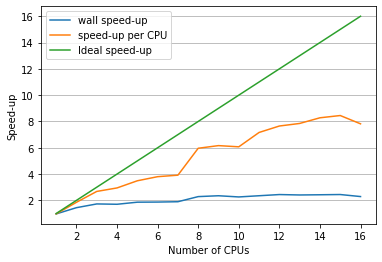

In [49]:
nruns=10
print('cpu changes, runs per experiment: %s'%nruns)
proctimes=[]
walltimes=[]
for nt in range(1,maxcpus+1):
    proctotal = 0
    walltotal = 0
    for run in range(nruns):
        start = time.time()
        stpr = time.process_time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid, rdiff, gridwidth, gridheight)
        end = time.time()
        endpr = time.process_time()
        proctotal+=(endpr - stpr)
        walltotal+=(end - start)
        avgtw = walltotal/nruns
        avgtp = proctotal/nruns/nt
        if nt==1: 
            Tseqp=avgtp
            Tseqw=avgtw
    print('average time wall: %.2f sec, average time CPU: %.2f sec, threads: %s'%(avgtw, avgtp,nt))
    proctimes+=[Tseq/avgtp]
    walltimes+=[Tseq/avgtw]
# plot
plotspeedup(walltimes, proctimes, maxcpus)

### cython (with shared memory) chunks 

In [13]:
print('chunk changes')
nt = 10
print('rows / threads: %.0f threads: %s' % ((npday.shape[0] / nt),nt))
nruns=20
for cs in range(1,400000,10000):
    totalrun = 0
    for run in range(nruns):
        start = time.time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, 'static', cs)
        end = time.time()
        totalrun+=(end - start)
        avgt = totalrun/nruns
        if nt==1: Tseq=avgt
    print('average time: %.2f chunk: %s'%(totalrun/nruns, cs))

chunk changes
rows / threads: 37292 threads: 10
time: 0.32 chunk: 1
time: 0.28 chunk: 10001
time: 0.28 chunk: 20001
time: 0.29 chunk: 30001
time: 0.26 chunk: 40001
time: 0.27 chunk: 50001
time: 0.28 chunk: 60001
time: 0.29 chunk: 70001
time: 0.31 chunk: 80001
time: 0.32 chunk: 90001
time: 0.33 chunk: 100001
time: 0.34 chunk: 110001
time: 0.36 chunk: 120001
time: 0.37 chunk: 130001
time: 0.38 chunk: 140001
time: 0.39 chunk: 150001
time: 0.40 chunk: 160001
time: 0.41 chunk: 170001
time: 0.43 chunk: 180001
time: 0.43 chunk: 190001
time: 0.44 chunk: 200001
time: 0.45 chunk: 210001
time: 0.46 chunk: 220001
time: 0.48 chunk: 230001
time: 0.49 chunk: 240001
time: 0.50 chunk: 250001
time: 0.51 chunk: 260001
time: 0.52 chunk: 270001
time: 0.53 chunk: 280001
time: 0.54 chunk: 290001
time: 0.54 chunk: 300001
time: 0.58 chunk: 310001
time: 0.58 chunk: 320001
time: 0.58 chunk: 330001
time: 0.58 chunk: 340001
time: 0.59 chunk: 350001
time: 0.61 chunk: 360001
time: 0.62 chunk: 370001
time: 0.63 chunk

### cython (with shared memory) OpenMP schedules

In [ ]:
nt = 14
nruns=30
print('optimum rows / threads: %.0f, threads: %s, runs per experiment: %s' % ((npday.shape[0] / nt),nt, nruns))
for i in range(3):
    id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, None)
schedules = [None, 'static', 'dynamic', 'guided']
random.shuffle(schedules)
for schedule in schedules:
    totalrun = 0
    for run in range(nruns):
        start = time.time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, schedule)
        end = time.time()
        totalrun+=(end - start)
    print('average time: %.2f sec, schedule: %s'%(totalrun/nruns, schedule))

#xaday=xarray.DataArray(data=grid, dims=["x", "y", "feature"],  coords=dict(x=range(gridwidth), y=range(gridheight), feature=range(len(dt_df.names)-1)))



### Table Conversion plus IO read/write (csv to netcdf)

In [179]:
def creategrid_xs_small(rdiff, firstid, gridwidth, gridheight, dayfile, pcpus, ccpus, queue):
    # fday = '/data2/ffp/datasets/daily/2021/08/20210803_norm.csv'
    #print("processing day %s" % dayfile)
    try:
        stpr = time.process_time()
        orig_path = os.path.dirname(dayfile)
        fname = os.path.basename(dayfile)
        daygrid = "%s_grid.nc" % (fname[0:8])
        #if os.path.isfile(os.path.join(orig_path, daygrid)): return
        dt_df = dt.fread(dayfile, nthreads=1)#pcpus)
        firstfeat = dt_df.names.index('id')
        #npday = dt_df[:, firstfeat:].to_numpy(dt.float32)

        dynamic_feat=['id', 'max_temp', 'min_temp', 'mean_temp', 'res_max',
         'dom_vel', 'rain_7days', #'dem', 'slope', 'curvature', 'aspect',
         'ndvi_new', 'evi', 'lst_day', 'lst_night', 'max_dew_temp',
         'mean_dew_temp', 'min_dew_temp', 'fire', 'dir_max_1', 'dir_max_2',
         'dir_max_3', 'dir_max_4', 'dir_max_5', 'dir_max_6', 'dir_max_7',
         'dir_max_8', 'dom_dir_1', 'dom_dir_2', 'dom_dir_3', 'dom_dir_4',
         'dom_dir_5', 'dom_dir_6', 'dom_dir_7', 'dom_dir_8', #'corine_111',
        # 'corine_112', 'corine_121', 'corine_122', 'corine_123', 'corine_124',
        # 'corine_131', 'corine_132', 'corine_133', 'corine_141', 'corine_142',
        # 'corine_211', 'corine_212', 'corine_213', 'corine_221', 'corine_222',
        # 'corine_223', 'corine_231', 'corine_241', 'corine_242', 'corine_243',
        # 'corine_244', 'corine_311', 'corine_312', 'corine_313', 'corine_321',
        # 'corine_322', 'corine_323', 'corine_324', 'corine_331', 'corine_332',
        # 'corine_333', 'corine_334', 'corine_411', 'corine_412', 'corine_421',
        # 'corine_422', 'corine_511', 'corine_512', 'corine_521', 'wkd_0',
        # 'wkd_1', 'wkd_2', 'wkd_3', 'wkd_4', 'wkd_5', 'wkd_6', 'month_7',
        # 'month_4', 'month_5', 'month_6', 'month_8', 'month_9',
        'frequency','f81',]# 'xpos', 'ypos']

        dyn_df = dt_df[:, dynamic_feat]
        npday = dyn_df.to_numpy(dt.float32)

        # start = time.time()
        id2xy, grid = nppar.fillcube(ccpus, npday, firstid, rdiff, gridwidth, gridheight)
        # end = time.time()
        # print(end - start)

        vardict = {}
        for i in range(0, len(dyn_df.names)):
            varname = dyn_df.names[i]
            if dyn_df.names[i] == 'x' or dyn_df.names[i] == 'y':
                varname = '%spos' % varname
            vardict[varname] = (["x", "y", "time"], np.expand_dims(grid[:, :, i], axis=2))

        t = datetime.strptime(os.path.basename(dayfile)[0:8], '%Y%m%d')
        xsday = xarray.Dataset(data_vars=vardict, coords=dict(x=range(gridwidth), y=range(gridheight), time=[t]))
        xsday.to_netcdf(os.path.join(orig_path, daygrid))
        #print("Successfull convertion %s" % dayfile)
        epr = time.process_time()
        queue.put(epr-stpr)
    except:
        print("Fail to convert %s" % dayfile)
        traceback.print_exc()
        with open("/data2/ffp/datasets/daily/failedgrids.log", "a") as f:
            f.write(dayfile)

def new_process(proclist, day, pthreads, cthreads):
    q=mp.Queue()
    proclist += [{'proc':Process(target=creategrid, args=(day, pthreads, cthreads, q)), 'queue': q}]
    proclist[-1]['proc'].start()

def create_xs_files(creategrid, days, pthreads, cthreads):
    procs=[]
    proctimetotal=0
    dayscompleted=[]
    for cpu in range(pthreads):
        d=days.pop()
        dayscompleted+=[d]
        new_process(procs, d, pthreads, cthreads)
    while True:
        time.sleep(1)
        for p in procs:
            try:
                proctimetotal+=p['queue'].get_nowait()
            except:
                pass
            if not p['proc'].is_alive():
                procs.remove(p)
        while len(procs)<pthreads:
            if len(days)==0: break
            d = days.pop()
            dayscompleted += [d]
            new_process(procs, d, pthreads, cthreads)
    return proctimetotal

def plotscatter(atimes, typ=0):
    for y in range(1,atimes.shape[1]):
        plt.scatter(range(1,atimes.shape[0]), [y]*(atimes.shape[0]-1), s=atimes[1:, y, typ])
    plt.show()

def plotheatmap(atimes):
    fig = plt.figure(figsize=(12, 6))
    grid = axes_grid1.AxesGrid(
        fig, 111, nrows_ncols=(1, 2), axes_pad = 0.5, cbar_location = "right",
        cbar_mode="each", cbar_size="7%", cbar_pad="5%",)
    data=atimes[1:,1:,0]
    im0 = grid[0].imshow(data, cmap='turbo', interpolation='None')
    grid.cbar_axes[0].colorbar(im0)
    # Show all ticks and label them with the respective list entries
    grid[0].set_xticks(np.arange(data.shape[1]), labels=np.arange(1,data.shape[1]+1))
    grid[0].set_yticks(np.arange(data.shape[0]), labels=np.arange(1,data.shape[0]+1))
    grid[0].set_ylabel('# cython threads')
    grid[0].set_xlabel('# python threads')
    grid[0].title.set_text('Wall time')
    #ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

    data=atimes[1:,1:,1]
    im1 = grid[1].imshow(data, cmap='turbo', interpolation='None')
    grid[1].set_xticks(np.arange(data.shape[1]), labels=np.arange(1,data.shape[1]+1))
    grid[1].set_xlabel('# python threads')
    grid[1].title.set_text('Process (CPU) time')
    grid.cbar_axes[1].colorbar(im1)
    

In [178]:
creategrid = partial(creategrid_xs_small, rdiff, firstid, gridwidth, gridheight)
nruns=1
totalrun=0
ctr=range(1,17,1)
ptr=range(1,11,1)
atimes=np.zeros((max(list(ctr))+1,max(list(ptr))+1,2))
for cthreads in ctr:
    for pthreads in ptr:
        start=time.time()
        proctime=create_xs_files(creategrid, dayfiles[:10], pthreads, cthreads)
        end=time.time()
        print('wall time: %.1f sec, process time: %.1f sec, python threads %s, cython threads %s' % (end - start, proctime, pthreads, cthreads))
        atimes[cthreads, pthreads,:]=np.array([end-start,proctime])[:]
np.save('tab2convtimes',atimes)        

wall time: 52.9 sec, process time: 27.4 sec, python threads 1, cython threads 1
wall time: 35.8 sec, process time: 40.6 sec, python threads 2, cython threads 1
wall time: 26.7 sec, process time: 38.7 sec, python threads 3, cython threads 1
wall time: 22.8 sec, process time: 36.9 sec, python threads 4, cython threads 1
wall time: 23.7 sec, process time: 33.4 sec, python threads 5, cython threads 1
wall time: 26.7 sec, process time: 37.5 sec, python threads 6, cython threads 1
wall time: 23.7 sec, process time: 40.5 sec, python threads 7, cython threads 1
wall time: 25.7 sec, process time: 49.6 sec, python threads 8, cython threads 1
wall time: 24.7 sec, process time: 23.1 sec, python threads 9, cython threads 1
wall time: 23.8 sec, process time: 7.6 sec, python threads 10, cython threads 1
wall time: 55.8 sec, process time: 28.5 sec, python threads 1, cython threads 2
wall time: 33.8 sec, process time: 37.7 sec, python threads 2, cython threads 2
wall time: 24.7 sec, process time: 40.1 

KeyboardInterrupt: 

Fail to convert /data2/ffp/datasets/daily/2015/09/20150928_norm.csv


Traceback (most recent call last):
  File "<ipython-input-174-c0f2e4b52ddf>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150920_norm.csv


Traceback (most recent call last):
  File "<ipython-input-174-c0f2e4b52ddf>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


In [108]:
np.save('tab2convtimes',atimes)

In [170]:
atimes=np.load('tab2convtimes.npy')

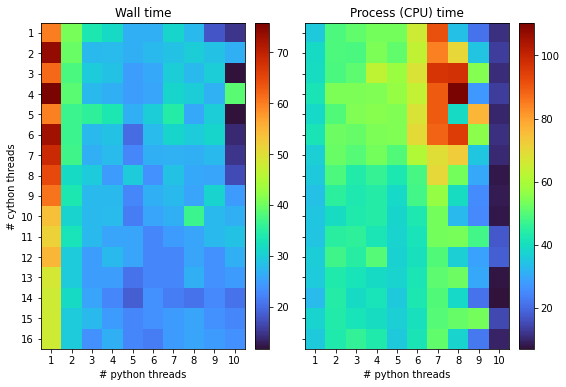

In [171]:
plotheatmap(atimes)

In [173]:
creategrid = partial(creategrid_xs_small, rdiff, firstid, gridwidth, gridheight)
nruns=1
totalrun=0
ctr=range(1,17,1)
ptr=range(1,17,1)
atimes2=np.zeros((max(list(ctr))+1,max(list(ptr))+1,2))
for cthreads in ctr:
    for pthreads in ptr:
        start=time.time()
        proctime=create_xs_files(creategrid, dayfiles[:pthreads], pthreads, cthreads)
        end=time.time()
        print('wall time: %.1f sec, process time: %.1f sec, python threads %s, cython threads %s' % (end - start, proctime, pthreads, cthreads))
        atimes2[cthreads, pthreads,:]=np.array([end-start,proctime])[:]
np.save('tab2convtimes2',atimes2)        

wall time: 13.1 sec, process time: 3.1 sec, python threads 1, cython threads 1
wall time: 10.2 sec, process time: 5.8 sec, python threads 2, cython threads 1
wall time: 12.2 sec, process time: 11.3 sec, python threads 3, cython threads 1
wall time: 13.3 sec, process time: 11.9 sec, python threads 4, cython threads 1
wall time: 19.4 sec, process time: 18.1 sec, python threads 5, cython threads 1
wall time: 22.4 sec, process time: 18.4 sec, python threads 6, cython threads 1
wall time: 17.5 sec, process time: 6.1 sec, python threads 7, cython threads 1
wall time: 20.6 sec, process time: 13.9 sec, python threads 8, cython threads 1
wall time: 23.6 sec, process time: 7.1 sec, python threads 9, cython threads 1


KeyboardInterrupt: 

Fail to convert /data2/ffp/datasets/daily/2015/09/20150908_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150928_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150912_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150914_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150923_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150905_norm.csvFail to convert /data2/ffp/datasets/daily/2015/09/20150911_norm.csvFail to convert /data2/ffp/datasets/daily/2015/09/20150925_norm.csv



Traceback (most recent call last):
Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(


  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
Traceback (most recent call last):
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_sm

Fail to convert /data2/ffp/datasets/daily/2015/09/20150910_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt


Fail to convert /data2/ffp/datasets/daily/2015/09/20150920_norm.csv


Traceback (most recent call last):
  File "<ipython-input-166-e860f3432324>", line 50, in creategrid_xs_small
    xsday.to_netcdf(os.path.join(orig_path, daygrid))
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/core/dataset.py", line 1902, in to_netcdf
    return to_netcdf(
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/api.py", line 1088, in to_netcdf
    store.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/scipy_.py", line 237, in close
    self._manager.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/data2/ffp/envs/ml_vm2/lib/python3.9/site-packages/scipy/io/_netcdf.py", line 312, in close
    self.fp.close()
KeyboardInterrupt
